<a href="https://colab.research.google.com/github/ferrari-leo/training/blob/main/nlp_with_python/06_deep_learning/02_qa_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Input, Dense, Permute, Dropout, add, dot, concatenate, LSTM, Embedding
%matplotlib inline

In [8]:
folder_path = '/content/drive/MyDrive/NLP Udemy'

In [11]:
with open(os.path.join(folder_path, 'train_qa.txt'), 'rb') as f:
  train_data = pickle.load(f)

In [12]:
with open(os.path.join(folder_path, 'test_qa.txt'), 'rb') as f:
  test_data = pickle.load(f)

In [17]:
[' '.join(t) for t in train_data[0]]

['Mary moved to the bathroom . Sandra journeyed to the bedroom .',
 'Is Sandra in the hallway ?',
 'n o']

In [18]:
# create vocabulary
all_data = test_data + train_data
vocab = set()
for s, q, a in all_data:
  vocab = vocab.union(set(s))
  vocab = vocab.union(set(q))
vocab.add('no')
vocab.add('yes')

In [20]:
vocab_len = len(vocab) + 1

In [32]:
# longest story
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lens)

# longest question
max_question_len = max([len(data[1]) for data in all_data])

In [24]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [25]:
tokenizer.word_index

{'in': 1,
 'kitchen': 2,
 '?': 3,
 'down': 4,
 'got': 5,
 'is': 6,
 'to': 7,
 'travelled': 8,
 'milk': 9,
 'bedroom': 10,
 'up': 11,
 'discarded': 12,
 'yes': 13,
 'grabbed': 14,
 'bathroom': 15,
 'john': 16,
 'back': 17,
 'garden': 18,
 'apple': 19,
 '.': 20,
 'hallway': 21,
 'no': 22,
 'took': 23,
 'put': 24,
 'went': 25,
 'left': 26,
 'journeyed': 27,
 'picked': 28,
 'mary': 29,
 'moved': 30,
 'football': 31,
 'sandra': 32,
 'daniel': 33,
 'office': 34,
 'dropped': 35,
 'there': 36,
 'the': 37}

In [26]:
train_story_text = []
train_question_test = []
train_answers = []
for s, q, a in train_data:
  train_story_text.append(s)
  train_question_test.append(q)
  train_answers.append(a)

In [27]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [33]:
def vectorize_stories(
    data,
    word_index=tokenizer.word_index,
    max_story_len=max_story_len,
    max_question_len=max_question_len
    ):
  # stories
  X = []
  # questions
  Xq = []
  # answers
  Y = []

  for s, q, a in data:
    x =  [word_index[word.lower()] for word in s]
    xq = [word_index[word.lower()] for word in q]
    y = np.zeros(len(word_index) + 1)
    y[word_index[a]] = 1

    X.append(x)
    Xq.append(xq)
    Y.append(y)

  return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [34]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [37]:
# placeholder shape=(max_story_len, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))
vocab_size = len(vocab) + 1

In [38]:
# input encoder M - output size (samples, max_story_len, embedding_dim)
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [39]:
# input encoder C - output size (samples, max_story_len, max_question_len)
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [40]:
# question encoder - output size (samples, max_question_len, embedding_dim)
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [41]:
# encoded <- encoder(input)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [43]:
match_out = dot([input_encoded_m, question_encoded], axes = (2,2))
match_out = Activation('softmax')(match_out)

In [44]:
response = add([match_out, input_encoded_c])
response = Permute((2,1))(response)

In [45]:
answer = concatenate([response, question_encoded])

In [47]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer) # (samples, vocab_size) with yes/no or 0

In [48]:
answer = Activation('softmax')(answer)

In [49]:
model = Model([input_sequence, question], answer)

In [50]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [52]:
history = model.fit(
    [inputs_train, queries_train],
    answers_train,
    batch_size=32,
    epochs = 100,
    validation_data = ([inputs_test, queries_test], answers_test)
    )

Epoch 1/100
313/313 [==============================] - 12s 25ms/step - loss: 0.9059 - accuracy: 0.4990 - val_loss: 0.7091 - val_accuracy: 0.4970
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 0.7075 - accuracy: 0.4987 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 3/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6984 - accuracy: 0.4953 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6964 - accuracy: 0.5011 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6960 - accuracy: 0.5013 - val_loss: 0.6941 - val_accuracy: 0.5030
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6959 - accuracy: 0.5001 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6956 - accuracy: 0.5008 - val_loss: 0.6935 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


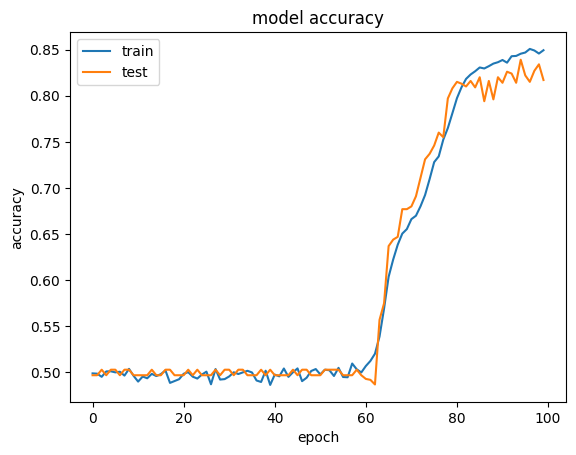

In [55]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [56]:
pred_results = model.predict(([inputs_test,queries_test]))

32/32 [==============================] - 1s 7ms/step


In [58]:
val_max = np.argmax(pred_results[0])

In [59]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [60]:
k

'no'

In [61]:
pred_results[0][val_max]

0.95013404

In [64]:
my_story = 'John left the kitchen . Sandra dropped the football in the garden .'.split()

In [66]:
my_question = 'Is the football in the garden ?'.split()

In [67]:
mydata = [(my_story, my_question, 'yes')]

In [68]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [69]:
my_pred = model.predict(([my_story, my_ques]))

1/1 [==============================] - 0s 45ms/step


In [70]:
val_max = np.argmax(my_pred[0])
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key
k

'yes'

In [71]:
my_pred[0][val_max]

0.89620185